# Project Introduction: Benchmarking Summaries using MediaSUM Dataset

## Scope of the Project
The primary objective of this project is to demonstrate the methodology for benchmarking text sentiment analysi

## Key Sections of the Notebook
1. Data Preprocessing
2. Sentiment classification with Roberta 
3. Performance Evaluation 

## Results
We do not make statisticaly significant findings; we use a small dataset for demo purposes only
  
Date: January 2025

In [28]:
from huggingface_hub import login
import openai
import os
import pandas as pd
import torch
from transformers import pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
print("\nSetting huggingface key...")
with open("../../.secrets/huggingface_token_2501_general_read.txt", 'r') as f:
    huggingface_access_token = f.read()
login(token=huggingface_access_token)


print("\nSetting openai key...")
with open("../../.secrets/2501-openai-rwx-key.key", 'r') as f:
    openai.api_key = f.read()
    os.environ["OPENAI_API_KEY"] = openai.api_key
    print("Key length: ", len(os.environ["OPENAI_API_KEY"]))



Setting huggingface key...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\johnt\.cache\huggingface\token
Login successful

Setting openai key...
Key length:  164


In [16]:

def clean_roberta_emotion(inference_model, text, max_tokens = 1000):
    ''' Roughly clean input text for bart using token estimation of 1 token = 4 characters '''
    # split input txt into chunks of max_tokens4 characters
    clipped_text = text[:max_tokens*4] 
    if len(clipped_text) < len(text):
        print("Dropped ",  len(text) - len(clipped_text), " characters.")
    
    return inference_model(clipped_text)[0]["label"]   


In [23]:
def get_template_oneshot_completion(catalogue_item_name: str, prompt_catalogue: pd.DataFrame, input_text: str,
                   model_name: str ="gpt-3.5-turbo", temperature: float = 0.25, verbose=False  ) -> str:
    """
    Generates a completion using OpenAI's ChatCompletion API based on the provided prompt configuration and input text.

    Args:
        prompt_config (dict): A dictionary containing the prompt configuration with keys such as 'unique_name', 'task_category', 'system_prompt', etc.
        input_text (str): The text to be summarized.

    Returns:
        str: The assistant's response (completion).

    Raises:
        Exception: If an error occurs during the OpenAI API call.
    """
    try:
        prompt_context = prompt_catalogue[prompt_catalogue["unique_name"] == catalogue_item_name].iloc[0].to_dict()
    except IndexError:
        raise ValueError(f"Unique name '{unique_name}' not found in the catalogue.")
    
    # Extract the system prompt from the prompt configuration
    system_prompt = prompt_context.get('system_prompt', 'You are a helpful chatbot.')
    user_prompt_example = prompt_context.get('user_prompt_example')
    assistant_response_example = prompt_context.get('assistant_response_example')
    user_message = input_text
    
    # Prepare the messages for the API call
    messages = [{"role": "system", "content": system_prompt}]
    # Optionally, you can provide an example user message and assistant response 
    if  user_prompt_example and assistant_response_example:
        messages.append( {"role": "user", "content": user_prompt_example} )
        messages.append( {"role": "assistant", "content": assistant_response_example} )
    messages.append({"role": "user", "content": user_message})

    if verbose:
        print(messages)
    
    client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    try:
        response = client.chat.completions.create(
            messages=messages,
            model=model_name,
            temperature=temperature,    # You can adjust the temperature for creativity (0.7-1) or factual (0-0.5)
        )
        # Extract the assistant's reply
        return response.choices[0].message.content
         
    except openai.OpenAIError as e:
        raise Exception(f"OpenAI API error: {str(e)}")
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {str(e)}")


# Read in MELD Data

***MELD Data Overview***

**Additional Processing:**
- Applied categorical labels to CNN data based on program (e.g. CNN's "Your money" = "busniness")
-  In this analysis we will use a  a smaller ~4k row dataset 



In [3]:
df = pd.read_json("MELD_Friends_test_sent_emo.json")
df.head(2)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,words,len_chars
0,1,why do all you’re coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",11,57
1,2,oh. that’s so monica can keep track. that way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",22,111


array([[<Axes: title={'center': 'len_chars'}>]], dtype=object)

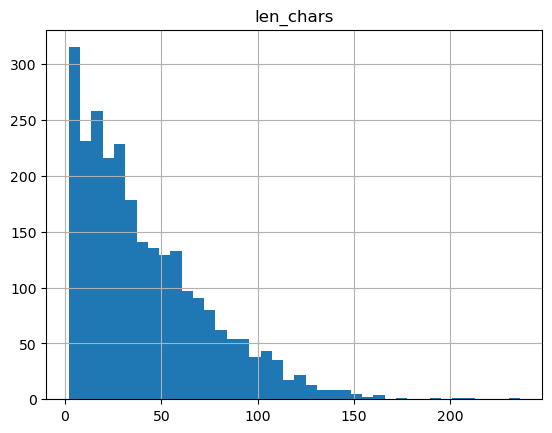

In [9]:
df[["len_chars"]].hist(bins=40)

In [15]:
sm = df[(df["len_chars"] > 2) & (df["len_chars"] < 150)].groupby('Emotion').sample(1) # smaller df
sm[["Emotion", "Utterance"]].groupby("Emotion").count()


,Utterance
Emotion,
anger,1
disgust,1
fear,1
joy,1
neutral,1
sadness,1
surprise,1


#### Summarization Techniques

**Emo-Roberta**
[https://huggingface.co/j-hartmann/emotion-english-distilroberta-base]

**OpenAI - GTP-3**  
[https://platform.openai.com/]

**Expected Performance**  

To-do

#### Emo-Roberta Sentiment

In [10]:
# Prepare BART Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
emo_roberta = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
print(device)

cpu


In [17]:
sm["Roberta_Sentiment"] = sm.Utterance.apply( lambda s : clean_roberta_emotion(emo_roberta, s) )

In [40]:
#Example
sm["Roberta_Sentiment"].iloc[1]

'surprise'

In [19]:
with torch.no_grad():
    torch.cuda.empty_cache()

#### Get GPT Summaries

In [21]:
prompt_catalogue = pd.read_excel("openai-api-prompts.xlsx", sheet_name="one-shot")
prompt_catalogue.head()

,unique_name,task_category,system_prompt,user_prompt_example,assistant_response_example
0,summarize_contextual_coreference,summarization,You are a helpful assistant that summarizes te...,Jeff: Can I train a Transformers model on Amaz...,Jeff wants to train a Transformers model on Am...
1,summarize_basic_instruction,summarization,Summarize the given dialogue text in two to th...,"If you or someone you know is out of a job, th...",Etiquette expert Peter Post advises people to ...
2,summarize_coreference,summarization,You are bot that summarizes text using a co-re...,"If you or someone you know is out of a job, th...",Career coach Ellen Gordon Reeves wants you to ...
3,sentiment_ekmans_emo,sentiment,You are a bot that classifies text sentiment a...,You had no right to take that money from my ac...,anger
4,sentiment_pnn,sentiment,You are a bot that classifies text sentiment a...,You had no right to take that money from my ac...,very negative


In [26]:
sm["gtp_sentiment_ekmans_emo"] = sm.Utterance.apply(lambda s : get_template_oneshot_completion("sentiment_ekmans_emo", prompt_catalogue, s) )

#### Compare the Classifiers  
todo 
**State of the Art**   
todo

**How can you Interpret the Scores?**  

Confusion Matrix: A table used to evaluate the performance of a classification model. It shows the actual vs. predicted classifications.  

True Positives (TP): Correctly predicted positive observations.  

True Negatives (TN): Correctly predicted negative observations.  

False Positives (FP): Incorrectly predicted positive observations.  

False Negatives (FN): Incorrectly predicted negative observations.  

Accuracy: The ratio of correctly predicted observations to the total observations. $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Precision: The ratio of correctly predicted positive observations to the total predicted positives. $$\text{Precision} = \frac{TP}{TP + FP}$$

Recall (Sensitivity): The ratio of correctly predicted positive observations to the all observations in the actual class. $$\text{Recall} = \frac{TP}{TP + FN}$$

F1-Score: The weighted average of Precision and Recall. $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Sources**  


In [41]:
# correct answer: Emotion
# prediction: gtp_sentiment_ekmans_emo
# show confusion matrix

sm[["Emotion", "gtp_sentiment_ekmans_emo","Roberta_Sentiment"]].groupby(["Emotion", "gtp_sentiment_ekmans_emo","Roberta_Sentiment"]).count()

,,
Emotion,gtp_sentiment_ekmans_emo,Roberta_Sentiment
anger,joy,joy
disgust,surprise,surprise
fear,joy,surprise
joy,joy,neutral
neutral,joy,anger
sadness,sadness,fear
surprise,surprise,surprise


### GTP Metrics

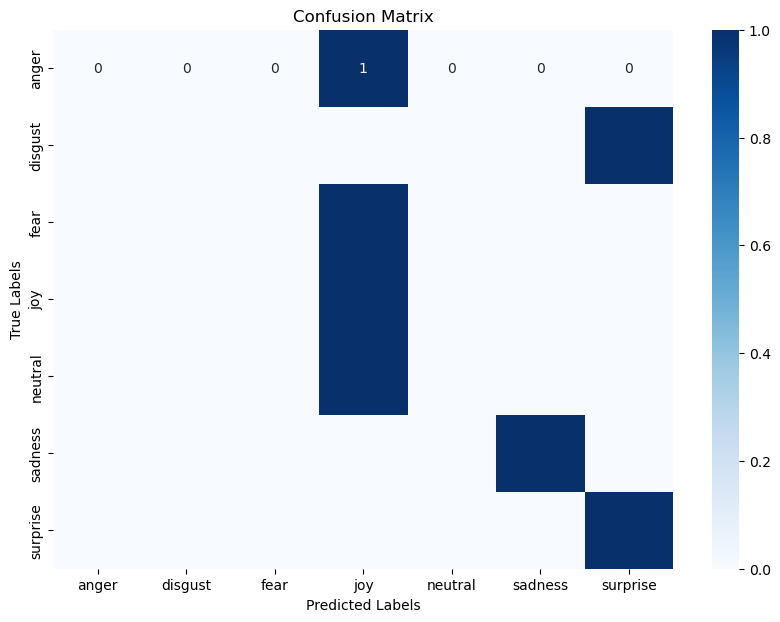

In [30]:
cm = confusion_matrix(sm["Emotion"], sm["gtp_sentiment_ekmans_emo"], labels=sm["Emotion"].unique())

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=sm["Emotion"].unique(), yticklabels=sm["Emotion"].unique(), cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Calculate accuracy
accuracy = accuracy_score(sm["Emotion"], sm["gtp_sentiment_ekmans_emo"])
accuracy


0.42857142857142855

In [35]:
# Calculate precision, recall, and F1-score for each class
precision = precision_score(sm["Emotion"], sm["gtp_sentiment_ekmans_emo"], average=None, labels=sm["Emotion"].unique())
recall = recall_score(sm["Emotion"], sm["gtp_sentiment_ekmans_emo"], average=None, labels=sm["Emotion"].unique())
f1 = f1_score(sm["Emotion"], sm["gtp_sentiment_ekmans_emo"], average=None, labels=sm["Emotion"].unique())


c:\Users\johnt\.conda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Print metrics
print(f'Overall Accuracy: {accuracy}')
for i, label in enumerate(sm["Emotion"].unique()):
    print(f'{label} - Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}')

Overall Accuracy: 0.42857142857142855
anger - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
disgust - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
fear - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
joy - Precision: 0.25, Recall: 1.0, F1-Score: 0.4
neutral - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
sadness - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
surprise - Precision: 0.5, Recall: 1.0, F1-Score: 0.6666666666666666


### Roberta Metrics

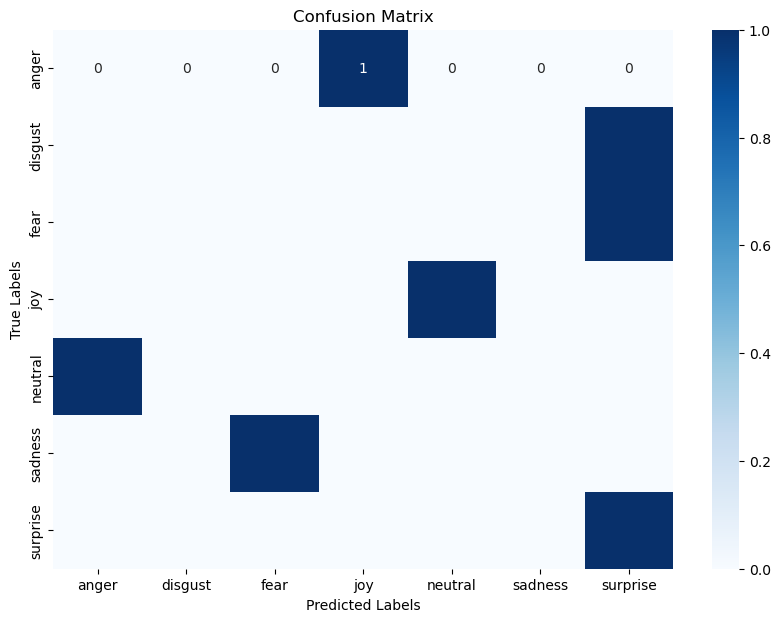

In [42]:
cm = confusion_matrix(sm["Emotion"], sm["Roberta_Sentiment"], labels=sm["Emotion"].unique())

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=sm["Emotion"].unique(), yticklabels=sm["Emotion"].unique(), cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(sm["Emotion"], sm["Roberta_Sentiment"])
accuracy

In [44]:
# Calculate precision, recall, and F1-score for each class
precision = precision_score(sm["Emotion"], sm["Roberta_Sentiment"], average=None, labels=sm["Emotion"].unique())
recall = recall_score(sm["Emotion"], sm["Roberta_Sentiment"], average=None, labels=sm["Emotion"].unique())
f1 = f1_score(sm["Emotion"], sm["Roberta_Sentiment"], average=None, labels=sm["Emotion"].unique())

print(f'Overall Accuracy: {accuracy}')
for i, label in enumerate(sm["Emotion"].unique()):
    print(f'{label} - Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}')

Overall Accuracy: 0.42857142857142855
anger - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
disgust - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
fear - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
joy - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
neutral - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
sadness - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
surprise - Precision: 0.3333333333333333, Recall: 1.0, F1-Score: 0.5


c:\Users\johnt\.conda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
